Install Required Libraries

In [1]:
!pip install pandas numpy matplotlib seaborn xgboost scikit-learn


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

Read csv

In [96]:
df1 = pd.read_csv("amazon_prime_titles.csv")
df2 = pd.read_csv("disney_plus_titles.csv")
df3 = pd.read_csv("hulu_titles.csv")
df4 = pd.read_csv("netflix_titles.csv")

In [97]:
print(df1.shape)
df1.head(2)

(9668, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...


In [98]:
print(df2.shape)
df2.head(2)

(1450, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...


In [99]:
print(df3.shape)
df3.head(2)

(3073, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Ricky Velez: Here's Everything,NaN,NaN,NaN,"October 24, 2021",2021,TV-MA,NaN,"Comedy, Stand Up",​Comedian Ricky Velez bares it all with his ho...
1,s2,Movie,Silent Night,NaN,NaN,NaN,"October 23, 2021",2020,NaN,94 min,"Crime, Drama, Thriller","Mark, a low end South London hitman recently r..."


In [100]:
print(df4.shape)
df4.head(2)

(8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


Data Preprocessing

In [101]:
merged_df.shape

(22998, 13)

In [102]:
merged_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [103]:
merged_df['genre'] = merged_df['listed_in'].str.split(',')

# Explode the list so each genre gets its own row
df_exploded = merged_df.explode('genre').reset_index(drop=True)

df_exploded.shape

(48303, 13)

In [104]:
unique_genres = df_exploded['genre'].unique()
unique_genres

array(['Comedy', ' Drama', 'Drama', ' International', 'Action',
       ' Suspense', 'Documentary', ' Fantasy', 'Fantasy', ' Kids',
       ' Special Interest', ' Science Fiction', 'Adventure', 'Horror',
       ' Sports', 'Kids', ' Talk Show and Variety', 'Science Fiction',
       ' Anime', ' Comedy', 'Arts', ' Entertainment', ' and Culture',
       'TV Shows', 'Animation', ' Adventure', ' Animation', 'Anime',
       'Music Videos and Concerts', 'Fitness', 'Faith and Spirituality',
       'Special Interest', ' Military and War', ' Western', 'Suspense',
       ' LGBTQ', ' Romance', ' Unscripted', 'Unscripted', ' Documentary',
       'Western', ' Faith and Spirituality', ' Young Adult Audience',
       'Arthouse', 'Sports', 'Military and War', ' Horror',
       'International', ' Music Videos and Concerts', ' Historical',
       'Romance', ' Arts', 'Young Adult Audience',
       'Talk Show and Variety', 'LGBTQ', ' Arthouse', 'Historical',
       ' Family', 'Musical', 'Docuseries', ' Music'

In [105]:
print(f"Number of unique genres: {len(unique_genres)}")

Number of unique genres: 204


In [106]:
genre_counts = df_exploded['genre'].value_counts()
display(genre_counts)

genre
Drama                    2658
 International Movies    2624
Action                   2212
Comedy                   2136
 Drama                   2070
                         ... 
 Police/Cop                 1
 Travel                     1
LGBTQ Movies                1
TV Sci-Fi & Fantasy         1
Sports Movies               1
Name: count, Length: 204, dtype: int64

In [107]:
df_exploded['genre'] = df_exploded['genre'].str.strip()

# Step 2: Map similar genres
genre_map = {
    # Drama variations
    'Drama': 'Drama', 'Dramas': 'Drama', 'TV Dramas': 'Drama', 'TV Horror': 'Drama',
    'Romantic TV Shows': 'Drama', 'Romantic Movies': 'Drama',

    # Comedy variations
    'Comedy': 'Comedy', 'Comedies': 'Comedy', 'Romantic Comedy': 'Comedy',
    'Stand-Up Comedy': 'Comedy', 'Stand-Up Comedy & Talk Shows': 'Comedy',
    'Sketch Comedy': 'Comedy', 'Sitcom': 'Comedy',

    # Action/Adventure
    'Action': 'Action/Adventure', 'Action-Adventure': 'Action/Adventure',
    'Action & Adventure': 'Action/Adventure', 'TV Action & Adventure': 'Action/Adventure',
    'Superhero': 'Action/Adventure',

    # Horror/Thriller
    'Horror': 'Horror/Thriller', 'Horror Movies': 'Horror/Thriller',
    'Thriller': 'Horror/Thriller', 'Thrillers': 'Horror/Thriller', 'TV Thrillers': 'Horror/Thriller',

    # Kids/Family
    'Kids': 'Kids/Family', "Kids' TV": 'Kids/Family', 'Children & Family Movies': 'Kids/Family',
    'Family': 'Kids/Family', 'Teen TV Shows': 'Kids/Family', 'Young Adult Audience': 'Kids/Family',

    # Sci-Fi/Fantasy
    'Science Fiction': 'Sci-Fi/Fantasy', 'Sci-Fi & Fantasy': 'Sci-Fi/Fantasy',
    'TV Sci-Fi & Fantasy': 'Sci-Fi/Fantasy', 'Fantasy': 'Sci-Fi/Fantasy', 'Anime': 'Sci-Fi/Fantasy',

    # Documentary
    'Documentary': 'Documentary', 'Docuseries': 'Documentary', 'Documentaries': 'Documentary',

    # Music/Concert
    'Music': 'Music/Performance', 'Music & Musicals': 'Music/Performance',
    'Music Videos and Concerts': 'Music/Performance', 'Concert Film': 'Music/Performance',
    'Sports Movies': 'Sports/Competition', 'Sports': 'Sports/Competition',

    # News/Politics
    'News': 'News/Politics', 'Faith & Spirituality': 'News/Politics', 'Faith and Spirituality': 'News/Politics',

    # Other categories (keep them as is or map more if needed)
}

# Apply mapping
df_exploded['genre'] = df_exploded['genre'].map(lambda x: genre_map.get(x, x))  # if not in map, keep original

# Check the new unique genres
print(df_exploded['genre'].value_counts())


genre
Drama                     8979
Comedy                    5488
Action/Adventure          3710
Kids/Family               3473
Documentary               3077
                          ... 
Soap Opera / Melodrama       2
Disaster                     2
Travel                       1
Talk Show                    1
Police/Cop                   1
Name: count, Length: 84, dtype: int64


In [108]:
df_exploded['genre'].value_counts().nlargest(25)

genre
Drama                     8979
Comedy                    5488
Action/Adventure          3710
Kids/Family               3473
Documentary               3077
International Movies      2752
Horror/Thriller           2406
Sci-Fi/Fantasy            1670
Suspense                  1501
International TV Shows    1351
Animation                 1089
Special Interest           980
Romance                    880
Adventure                  815
Independent Movies         756
Music/Performance          664
TV Comedies                581
International              571
Sports/Competition         561
Arts                       483
Entertainment              483
and Culture                483
Crime TV Shows             470
TV Shows                   279
Reality                    273
Name: count, dtype: int64

In [109]:
threshold = 500  # adjust as needed

# Count genres
genre_counts = df_exploded['genre'].value_counts()

# Get all genres above threshold
valid_genres = genre_counts[genre_counts >= threshold].index

# Filter df_exploded to keep only those genres
df = df_exploded[df_exploded['genre'].isin(valid_genres)].reset_index(drop=True)


In [110]:
df['genre'].value_counts()

genre
Drama                     8979
Comedy                    5488
Action/Adventure          3710
Kids/Family               3473
Documentary               3077
International Movies      2752
Horror/Thriller           2406
Sci-Fi/Fantasy            1670
Suspense                  1501
International TV Shows    1351
Animation                 1089
Special Interest           980
Romance                    880
Adventure                  815
Independent Movies         756
Music/Performance          664
TV Comedies                581
International              571
Sports/Competition         561
Name: count, dtype: int64

In [111]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'genre'],
      dtype='object')

In [112]:
df.shape

(41304, 13)

In [113]:
df['date_added'].isna().sum()

np.int64(15530)

In [114]:
df = df.dropna(subset=['date_added'])

In [115]:
df.shape

(25774, 13)

In [116]:
df['date_added'] = df['date_added'].str.strip()

In [117]:
df['date_added']

0          March 30, 2021
1          March 30, 2021
2          March 30, 2021
3          March 30, 2021
4          March 30, 2021
               ...       
41299    January 11, 2020
41300    January 11, 2020
41301       March 2, 2019
41302       March 2, 2019
41303       March 2, 2019
Name: date_added, Length: 25774, dtype: object

In [118]:
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y')
display(df['date_added'].head())

0   2021-03-30
1   2021-03-30
2   2021-03-30
3   2021-03-30
4   2021-03-30
Name: date_added, dtype: datetime64[ns]

In [119]:
df['date_added'].isna().sum()

np.int64(0)

In [120]:
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genre
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,2021-03-30,2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...,Comedy
1,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,2021-03-30,2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...,Drama


In [121]:
result = df.groupby(["date_added", "genre"]).size().reset_index(name="count")

In [122]:
pivot_df = result.pivot(index="date_added", columns="genre", values="count").fillna(0).astype(int)

In [123]:
pivot_df.head(4)

genre,Action/Adventure,Adventure,Animation,Comedy,Documentary,Drama,Horror/Thriller,Independent Movies,International,International Movies,International TV Shows,Kids/Family,Music/Performance,Romance,Sci-Fi/Fantasy,Special Interest,Sports/Competition,Suspense,TV Comedies
date_added,,,,,,,,,,,,,,,,,,,
2006-07-14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0
2008-01-01,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2008-02-04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2008-06-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Feature Engineering

In [124]:
lags = [1, 7, 30]
for col in pivot_df.columns:
    if col != 'date_added':  # skip date column
        for lag in lags:
            pivot_df[f"{col}_lag{lag}"] = pivot_df[col].shift(lag)
df_encoded = pivot_df.dropna()

Train Test Split

In [125]:
train_size = int(len(pivot_df) * 0.8)
train, test = pivot_df.iloc[:train_size], pivot_df.iloc[train_size:]


In [126]:
target = 'Comedy' 
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]


Model Training

In [127]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Model Evaluation

In [128]:
preds = model.predict(X_test)
print("R²:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R²: 0.6917159557342529
MSE: 5.495564937591553
RMSE: 2.344262130733582


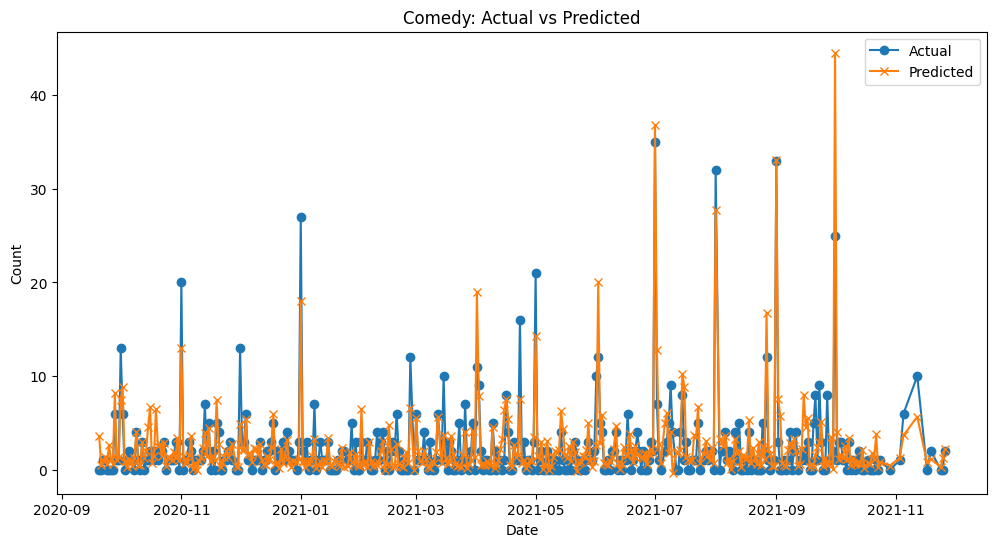

In [129]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, preds, label='Predicted', marker='x')
plt.title('Comedy: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

2020-09-20 00:00:00 2021-11-26 00:00:00


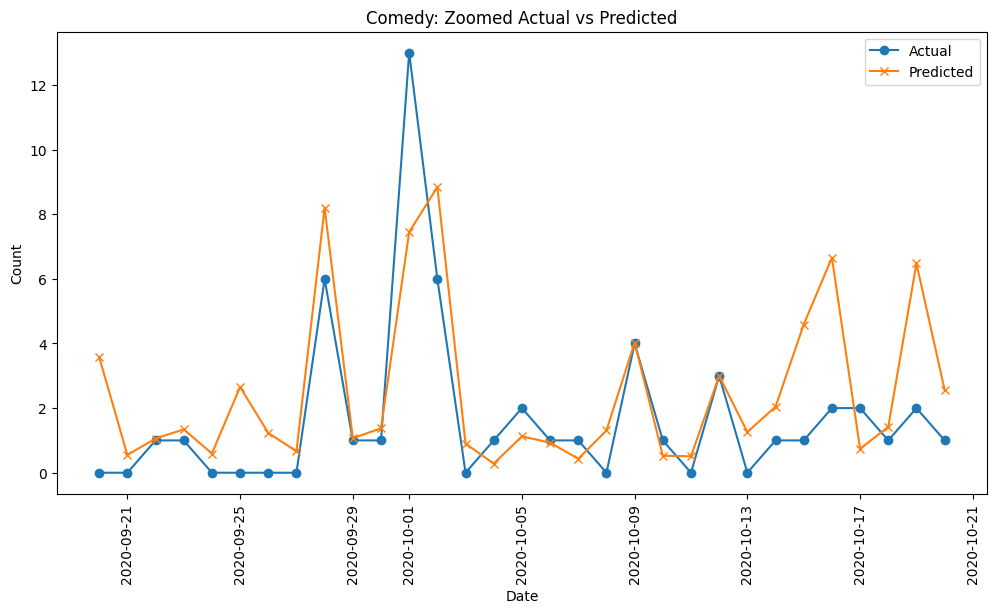

In [130]:
y_test_series = pd.Series(y_test.values, index=y_test.index)
preds_series = pd.Series(preds, index=y_test.index)

# Check actual min/max dates
print(y_test_series.index.min(), y_test_series.index.max())

# Pick a zoom range that actually exists in your test set
start_date = y_test_series.index.min()
end_date = start_date + pd.Timedelta(days=30)  # example: first 30 days

mask = (y_test_series.index >= start_date) & (y_test_series.index <= end_date)

plt.figure(figsize=(12,6))
plt.plot(y_test_series.index[mask], y_test_series[mask], label='Actual', marker='o')
plt.plot(preds_series.index[mask], preds_series[mask], label='Predicted', marker='x')
plt.title('Comedy: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [131]:
def trend_lifespan(y_series, threshold_ratio=0.5, smoothing_window=3):

    # Smooth the series to reduce noise
    smoothed = y_series.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Define threshold
    threshold = smoothed.mean() * threshold_ratio
    
    # Detect where the series is above threshold
    above_threshold = smoothed > threshold
    
    if above_threshold.any():
        start_date = above_threshold.idxmax()
        end_date = above_threshold[::-1].idxmax()
        peak_date = smoothed.idxmax()
        duration = (end_date - start_date).days
        return start_date, peak_date, end_date, duration
    else:
        return None, None, None, 0

# Example usage:
# Make sure y_test has datetime index
y_test.index = pd.to_datetime(y_test.index)
start, peak, end, duration = trend_lifespan(y_test)
print(f"Trend starts: {start}, peaks: {peak}, ends: {end}, lasts: {duration} days")

Trend starts: 2020-09-28 00:00:00, peaks: 2021-07-02 00:00:00, ends: 2021-11-19 00:00:00, lasts: 417 days


Model Training for targer "Drama"

In [132]:
target = 'Drama'  # now this column exists
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]


In [133]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [134]:
preds = model.predict(X_test)
print("R²:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R²: 0.7756773233413696
MSE: 8.652172088623047
RMSE: 2.9414574769360593


2020-09-20 00:00:00 2021-11-26 00:00:00


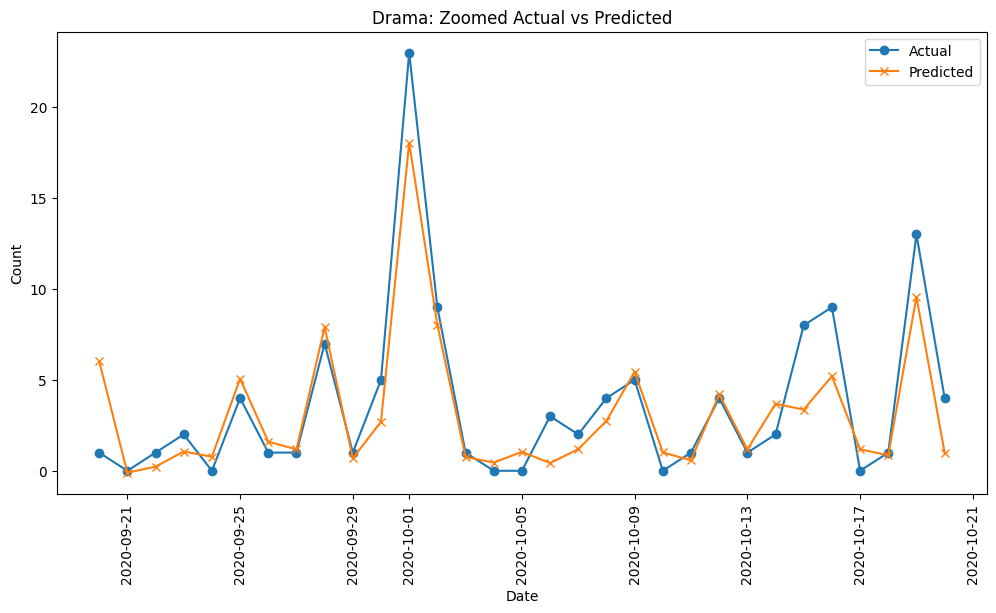

In [135]:
y_test_series = pd.Series(y_test.values, index=y_test.index)
preds_series = pd.Series(preds, index=y_test.index)

# Check actual min/max dates
print(y_test_series.index.min(), y_test_series.index.max())

# Pick a zoom range that actually exists in your test set
start_date = y_test_series.index.min()
end_date = start_date + pd.Timedelta(days=30)  # example: first 30 days

mask = (y_test_series.index >= start_date) & (y_test_series.index <= end_date)

plt.figure(figsize=(12,6))
plt.plot(y_test_series.index[mask], y_test_series[mask], label='Actual', marker='o')
plt.plot(preds_series.index[mask], preds_series[mask], label='Predicted', marker='x')
plt.title('Drama: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [136]:
def trend_lifespan(y_series, threshold_ratio=0.5, smoothing_window=3):

    # Smooth the series to reduce noise
    smoothed = y_series.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Define threshold
    threshold = smoothed.mean() * threshold_ratio
    
    # Detect where the series is above threshold
    above_threshold = smoothed > threshold
    
    if above_threshold.any():
        start_date = above_threshold.idxmax()
        end_date = above_threshold[::-1].idxmax()
        peak_date = smoothed.idxmax()
        duration = (end_date - start_date).days
        return start_date, peak_date, end_date, duration
    else:
        return None, None, None, 0

# Example usage:
# Make sure y_test has datetime index
y_test.index = pd.to_datetime(y_test.index)
start, peak, end, duration = trend_lifespan(y_test)
print(f"Trend starts: {start}, peaks: {peak}, ends: {end}, lasts: {duration} days")

Trend starts: 2020-09-25 00:00:00, peaks: 2021-07-03 00:00:00, ends: 2021-10-03 00:00:00, lasts: 373 days


Model training for target "Action/Adventure"

In [137]:
target = 'Action/Adventure'  # now this column exists
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]

In [138]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [139]:
preds = model.predict(X_test)
print("R²:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R²: 0.8138954639434814
MSE: 2.793243169784546
RMSE: 1.6712998443680134


2020-09-20 00:00:00 2021-11-26 00:00:00


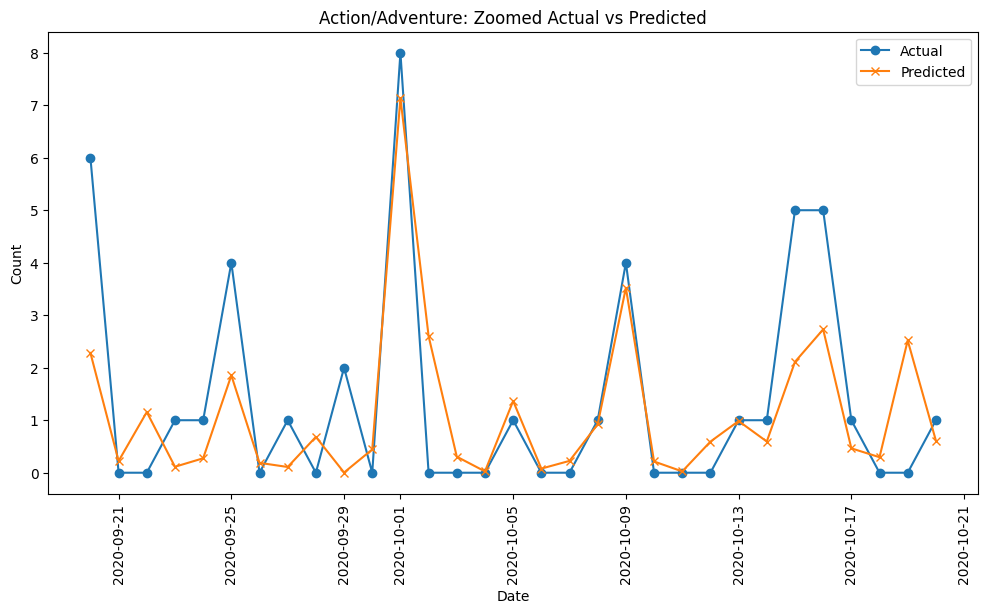

In [140]:
y_test_series = pd.Series(y_test.values, index=y_test.index)
preds_series = pd.Series(preds, index=y_test.index)

# Check actual min/max dates
print(y_test_series.index.min(), y_test_series.index.max())

# Pick a zoom range that actually exists in your test set
start_date = y_test_series.index.min()
end_date = start_date + pd.Timedelta(days=30)  # example: first 30 days

mask = (y_test_series.index >= start_date) & (y_test_series.index <= end_date)

plt.figure(figsize=(12,6))
plt.plot(y_test_series.index[mask], y_test_series[mask], label='Actual', marker='o')
plt.plot(preds_series.index[mask], preds_series[mask], label='Predicted', marker='x')
plt.title('Action/Adventure: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [141]:
def trend_lifespan(y_series, threshold_ratio=0.5, smoothing_window=3):

    # Smooth the series to reduce noise
    smoothed = y_series.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Define threshold
    threshold = smoothed.mean() * threshold_ratio
    
    # Detect where the series is above threshold
    above_threshold = smoothed > threshold
    
    if above_threshold.any():
        start_date = above_threshold.idxmax()
        end_date = above_threshold[::-1].idxmax()
        peak_date = smoothed.idxmax()
        duration = (end_date - start_date).days
        return start_date, peak_date, end_date, duration
    else:
        return None, None, None, 0

# Example usage:
# Make sure y_test has datetime index
y_test.index = pd.to_datetime(y_test.index)
start, peak, end, duration = trend_lifespan(y_test)
print(f"Trend starts: {start}, peaks: {peak}, ends: {end}, lasts: {duration} days")

Trend starts: 2020-09-20 00:00:00, peaks: 2021-10-02 00:00:00, ends: 2021-11-24 00:00:00, lasts: 430 days


Model Training and Evaluation for target 'Kids/Family'

In [142]:
target = 'Kids/Family'  # now this column exists
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]


In [143]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [144]:
preds = model.predict(X_test)
print("R²:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R²: 0.41191011667251587
MSE: 5.212615489959717
RMSE: 2.2831153036935556


2020-09-20 00:00:00 2021-11-26 00:00:00


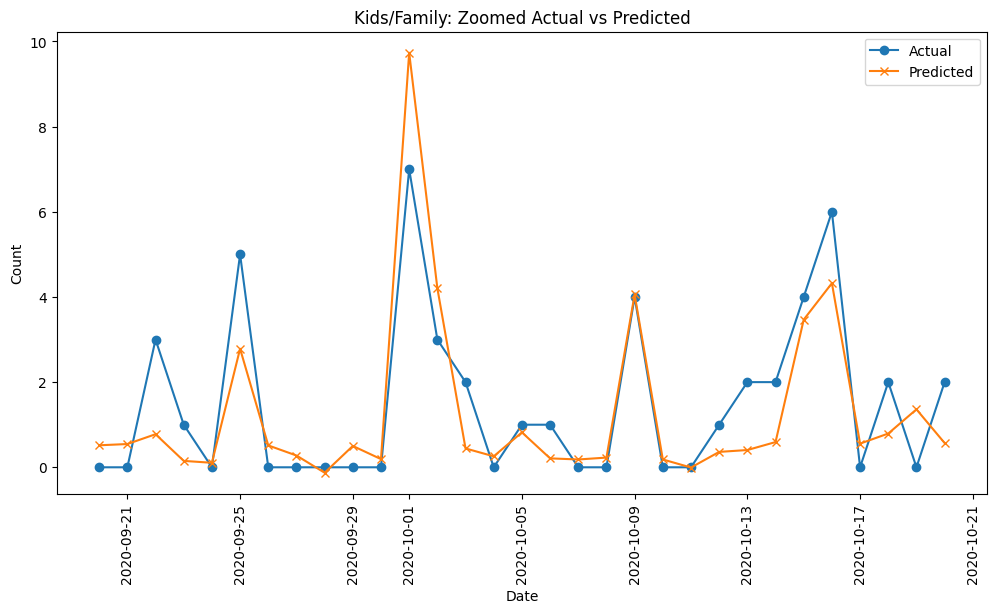

In [145]:
y_test_series = pd.Series(y_test.values, index=y_test.index)
preds_series = pd.Series(preds, index=y_test.index)

# Check actual min/max dates
print(y_test_series.index.min(), y_test_series.index.max())

# Pick a zoom range that actually exists in your test set
start_date = y_test_series.index.min()
end_date = start_date + pd.Timedelta(days=30)  # example: first 30 days

mask = (y_test_series.index >= start_date) & (y_test_series.index <= end_date)

plt.figure(figsize=(12,6))
plt.plot(y_test_series.index[mask], y_test_series[mask], label='Actual', marker='o')
plt.plot(preds_series.index[mask], preds_series[mask], label='Predicted', marker='x')
plt.title('Kids/Family: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [146]:
def trend_lifespan(y_series, threshold_ratio=0.5, smoothing_window=3):

    # Smooth the series to reduce noise
    smoothed = y_series.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Define threshold
    threshold = smoothed.mean() * threshold_ratio
    
    # Detect where the series is above threshold
    above_threshold = smoothed > threshold
    
    if above_threshold.any():
        start_date = above_threshold.idxmax()
        end_date = above_threshold[::-1].idxmax()
        peak_date = smoothed.idxmax()
        duration = (end_date - start_date).days
        return start_date, peak_date, end_date, duration
    else:
        return None, None, None, 0

# Example usage:
# Make sure y_test has datetime index
y_test.index = pd.to_datetime(y_test.index)
start, peak, end, duration = trend_lifespan(y_test)
print(f"Trend starts: {start}, peaks: {peak}, ends: {end}, lasts: {duration} days")

Trend starts: 2020-09-22 00:00:00, peaks: 2021-07-23 00:00:00, ends: 2021-11-26 00:00:00, lasts: 430 days


Model Training and Evaluation for target 'Documentary'

In [147]:
target = 'Documentary'  # now this column exists
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]


In [148]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [149]:
preds = model.predict(X_test)
print("R²:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R²: 0.10180151462554932
MSE: 3.9384968280792236
RMSE: 1.9845646444697194


2020-09-20 00:00:00 2021-11-26 00:00:00


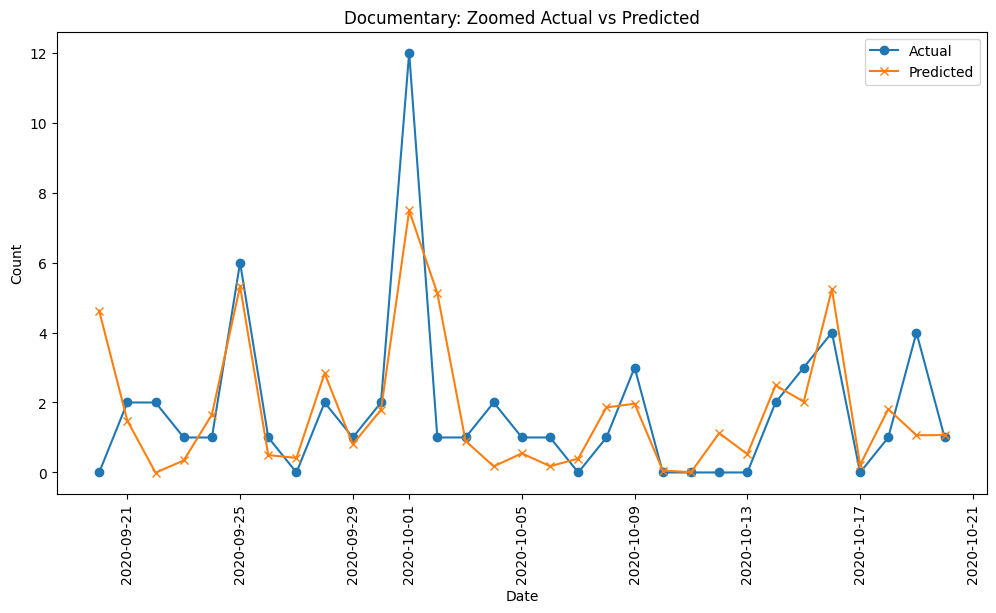

In [150]:
y_test_series = pd.Series(y_test.values, index=y_test.index)
preds_series = pd.Series(preds, index=y_test.index)

# Check actual min/max dates
print(y_test_series.index.min(), y_test_series.index.max())

# Pick a zoom range that actually exists in your test set
start_date = y_test_series.index.min()
end_date = start_date + pd.Timedelta(days=30)  # example: first 30 days

mask = (y_test_series.index >= start_date) & (y_test_series.index <= end_date)

plt.figure(figsize=(12,6))
plt.plot(y_test_series.index[mask], y_test_series[mask], label='Actual', marker='o')
plt.plot(preds_series.index[mask], preds_series[mask], label='Predicted', marker='x')
plt.title('Documentary: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [151]:
def trend_lifespan(y_series, threshold_ratio=0.5, smoothing_window=3):

    # Smooth the series to reduce noise
    smoothed = y_series.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Define threshold
    threshold = smoothed.mean() * threshold_ratio
    
    # Detect where the series is above threshold
    above_threshold = smoothed > threshold
    
    if above_threshold.any():
        start_date = above_threshold.idxmax()
        end_date = above_threshold[::-1].idxmax()
        peak_date = smoothed.idxmax()
        duration = (end_date - start_date).days
        return start_date, peak_date, end_date, duration
    else:
        return None, None, None, 0

# Example usage:
# Make sure y_test has datetime index
y_test.index = pd.to_datetime(y_test.index)
start, peak, end, duration = trend_lifespan(y_test)
print(f"Trend starts: {start}, peaks: {peak}, ends: {end}, lasts: {duration} days")

Trend starts: 2020-09-21 00:00:00, peaks: 2020-10-23 00:00:00, ends: 2021-11-26 00:00:00, lasts: 431 days


Model Training and Evaluation for target 'International Movies'

In [152]:
target = 'International Movies'  # now this column exists
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]


In [153]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [154]:
preds = model.predict(X_test)
print("R²:", r2_score(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R²: -0.23755192756652832
MSE: 6.770143508911133
RMSE: 2.6019499435829148


2020-09-20 00:00:00 2021-11-26 00:00:00


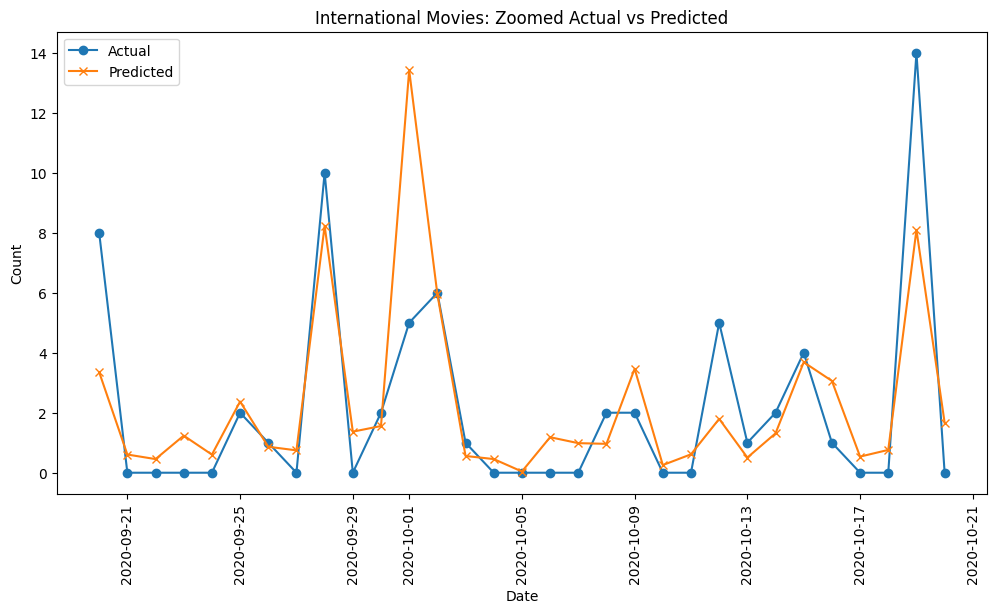

In [155]:
y_test_series = pd.Series(y_test.values, index=y_test.index)
preds_series = pd.Series(preds, index=y_test.index)

# Check actual min/max dates
print(y_test_series.index.min(), y_test_series.index.max())

# Pick a zoom range that actually exists in your test set
start_date = y_test_series.index.min()
end_date = start_date + pd.Timedelta(days=30)  # example: first 30 days

mask = (y_test_series.index >= start_date) & (y_test_series.index <= end_date)

plt.figure(figsize=(12,6))
plt.plot(y_test_series.index[mask], y_test_series[mask], label='Actual', marker='o')
plt.plot(preds_series.index[mask], preds_series[mask], label='Predicted', marker='x')
plt.title('International Movies: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [156]:
def trend_lifespan(y_series, threshold_ratio=0.5, smoothing_window=3):

    # Smooth the series to reduce noise
    smoothed = y_series.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Define threshold
    threshold = smoothed.mean() * threshold_ratio
    
    # Detect where the series is above threshold
    above_threshold = smoothed > threshold
    
    if above_threshold.any():
        start_date = above_threshold.idxmax()
        end_date = above_threshold[::-1].idxmax()
        peak_date = smoothed.idxmax()
        duration = (end_date - start_date).days
        return start_date, peak_date, end_date, duration
    else:
        return None, None, None, 0

# Example usage:
# Make sure y_test has datetime index
y_test.index = pd.to_datetime(y_test.index)
start, peak, end, duration = trend_lifespan(y_test)
print(f"Trend starts: {start}, peaks: {peak}, ends: {end}, lasts: {duration} days")

Trend starts: 2020-09-20 00:00:00, peaks: 2020-09-20 00:00:00, ends: 2021-09-24 00:00:00, lasts: 369 days


In [84]:
from sklearn.multioutput import MultiOutputRegressor

In [85]:
y_columns = [
    'Action/Adventure', 'Adventure', 'Animation', 'Comedy', 'Documentary',
    'Drama', 'Horror/Thriller', 'Independent Movies', 'International',
    'International Movies', 'International TV Shows', 'Kids/Family',
    'Music/Performance', 'Romance', 'Sci-Fi/Fantasy', 'Special Interest',
    'Sports/Competition', 'Suspense', 'TV Comedies'
]

# Targets
y_train = train[y_columns]
y_test = test[y_columns]

# Features = all remaining columns
X_columns = [c for c in df_encoded.columns if c not in y_columns]
X_train = train[X_columns]
X_test = test[X_columns]

In [86]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

multi_model = MultiOutputRegressor(xgb)
multi_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [87]:
preds = multi_model.predict(X_test)

# Convert preds to DataFrame with genre columns
preds_df = pd.DataFrame(preds, index=y_test.index, columns=y_test.columns)

In [88]:
results = {}
for col in y_test.columns:
    mse = mean_squared_error(y_test[col], preds_df[col])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[col], preds_df[col])
    results[col] = {'RMSE': rmse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                             RMSE         R2
Action/Adventure         7.781668  -3.034536
Adventure                2.377540   0.026005
Animation                8.591877 -62.398319
Comedy                   8.982629  -3.526323
Documentary              3.202235  -1.338558
Drama                    6.565151  -0.117474
Horror/Thriller          3.326220   0.046139
Independent Movies       0.894483  -0.581532
International            0.539397  -0.272579
International Movies     3.521759  -1.267174
International TV Shows   1.564029  -0.225788
Kids/Family             12.540322 -16.742115
Music/Performance        1.092855  -0.617707
Romance                  1.054350   0.025030
Sci-Fi/Fantasy           4.730768  -9.063223
Special Interest         0.218218  -0.039633
Sports/Competition       0.979938  -0.617509
Suspense                 0.218218  -0.022801
TV Comedies              0.972082  -0.094142


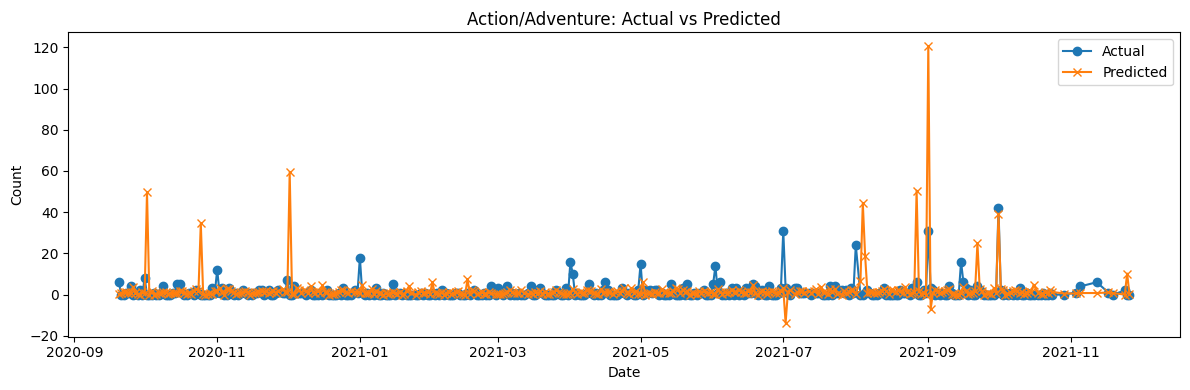

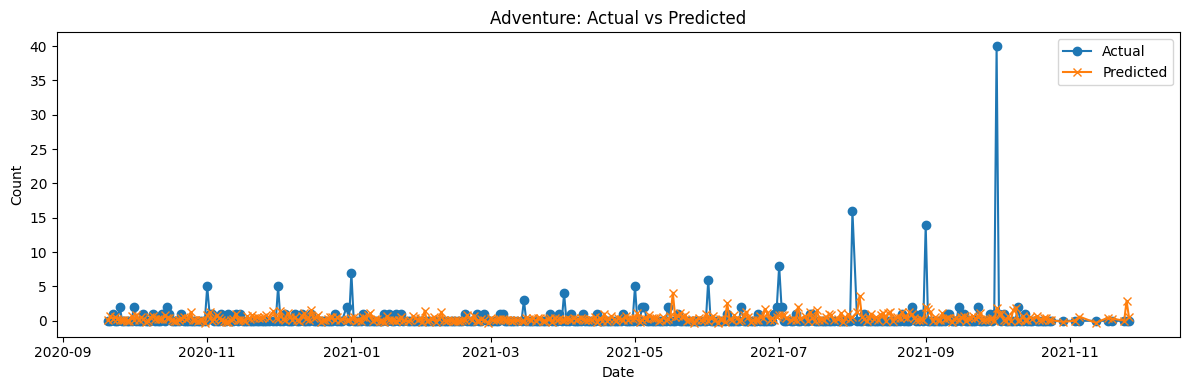

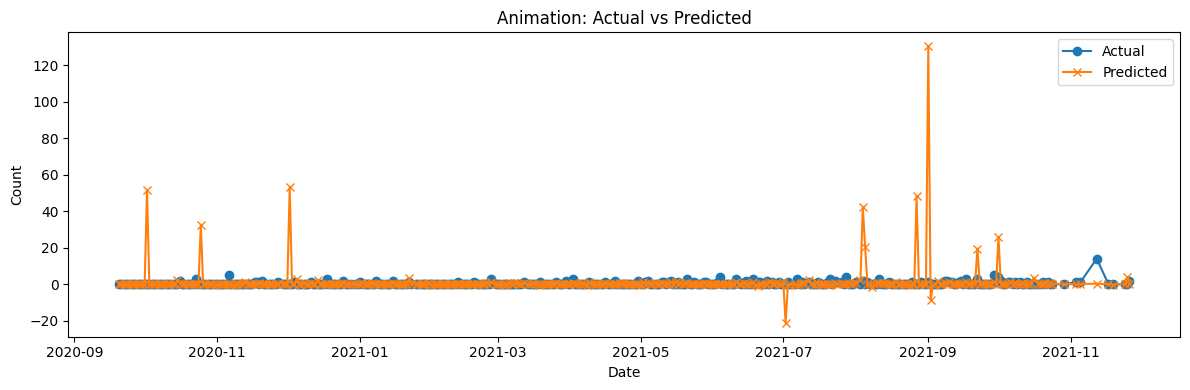

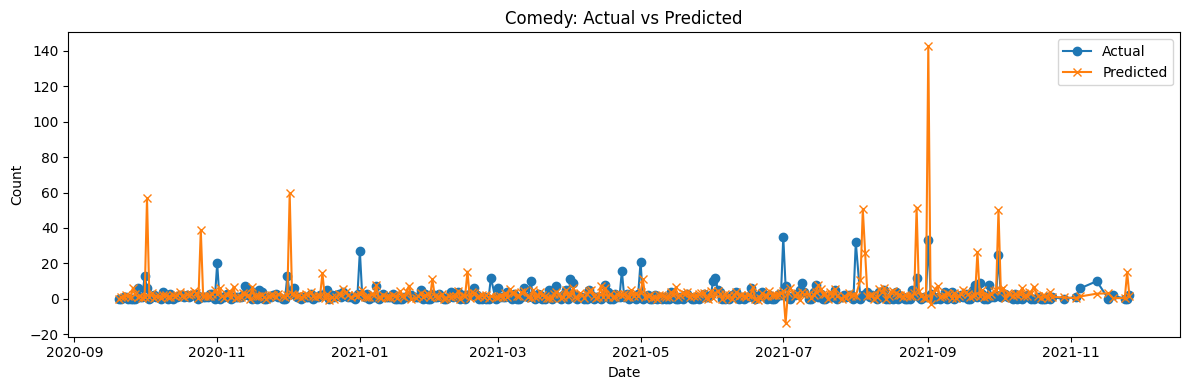

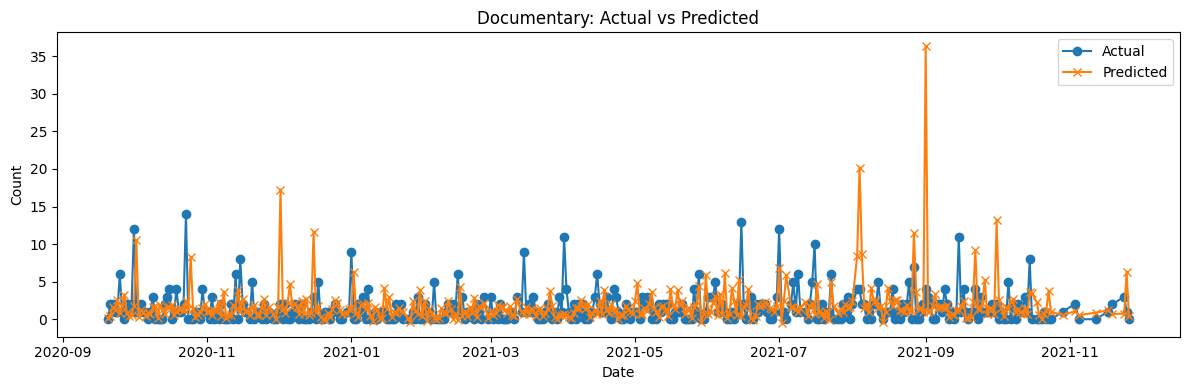

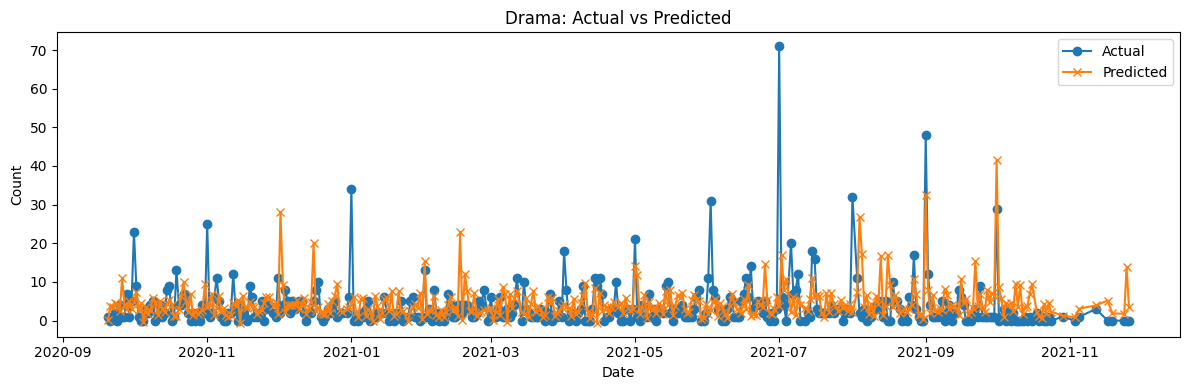

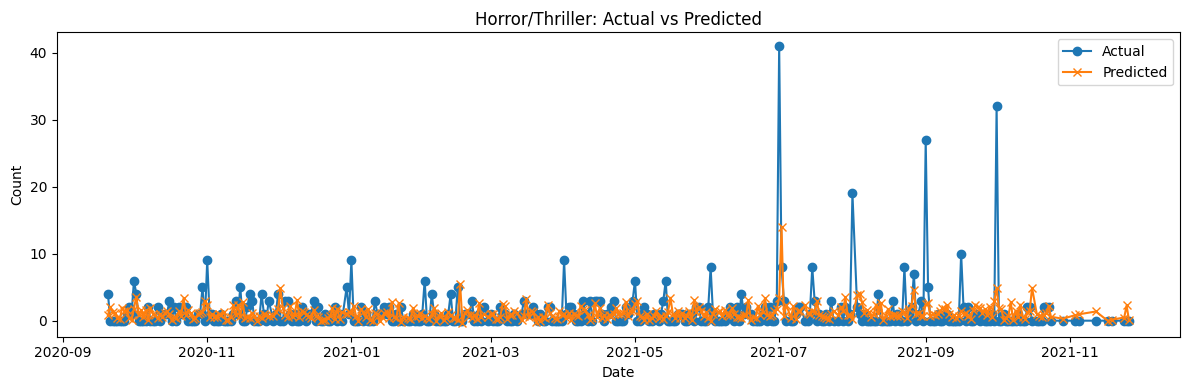

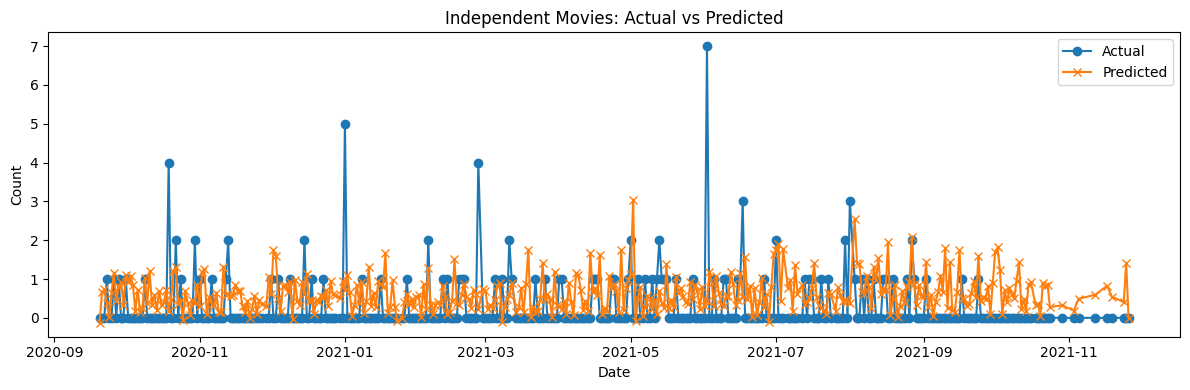

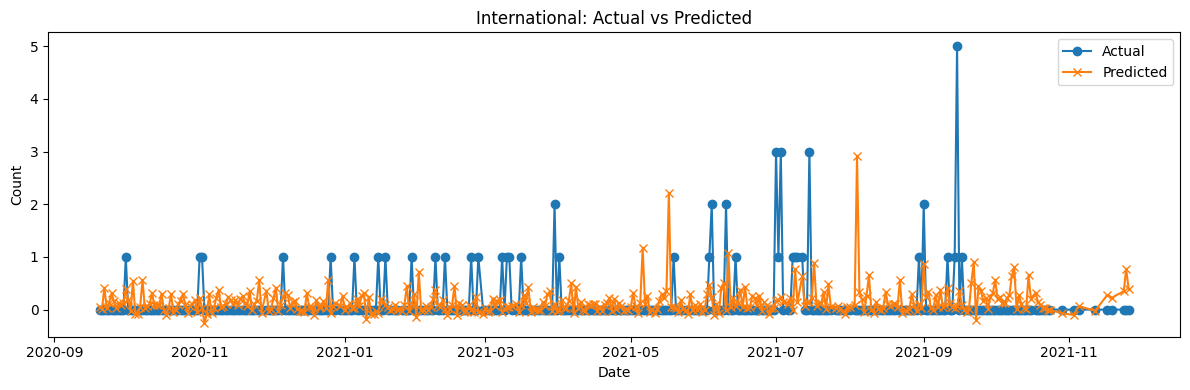

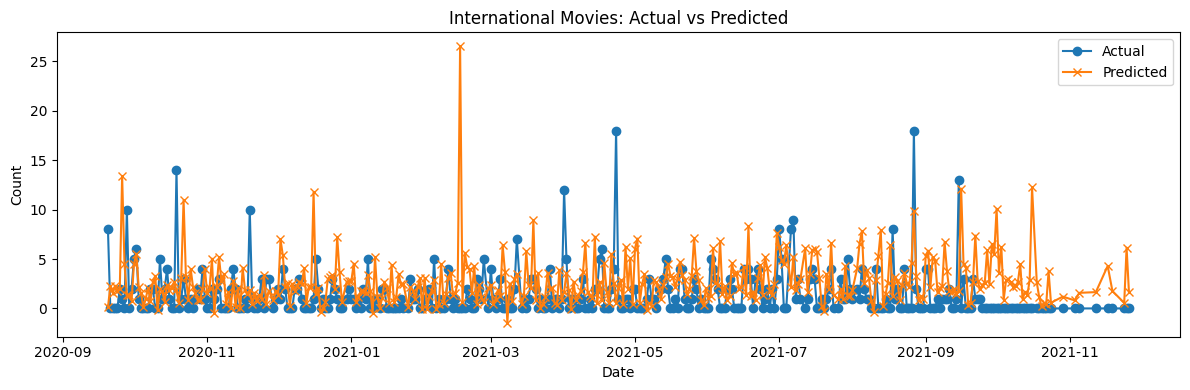

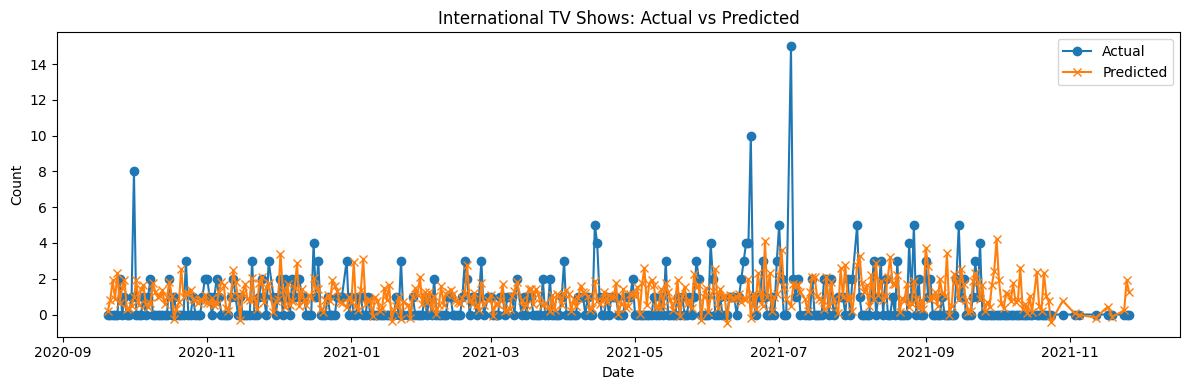

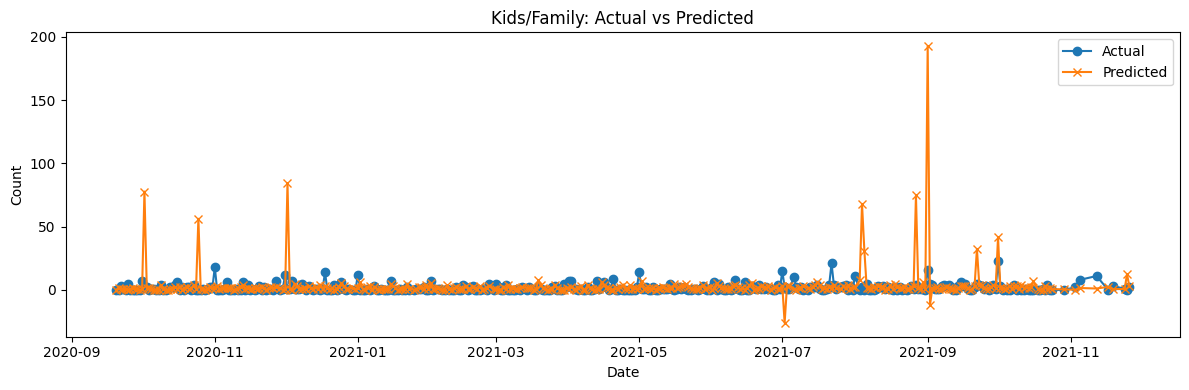

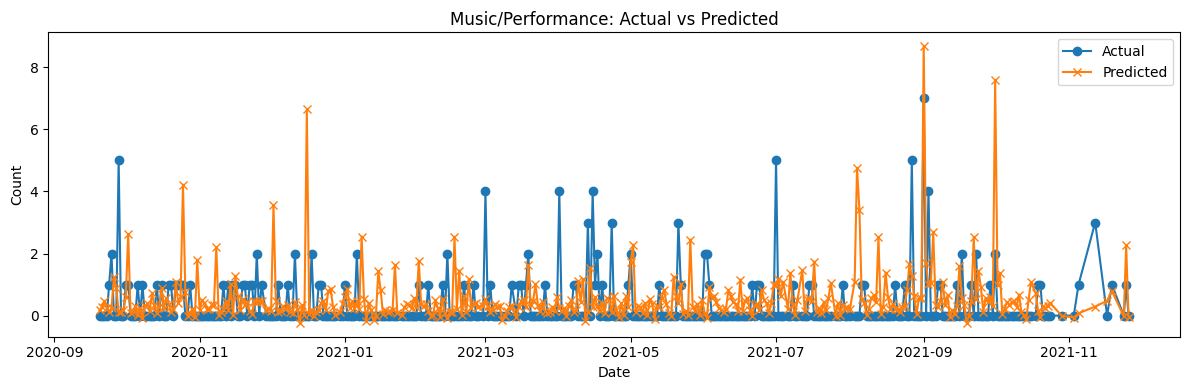

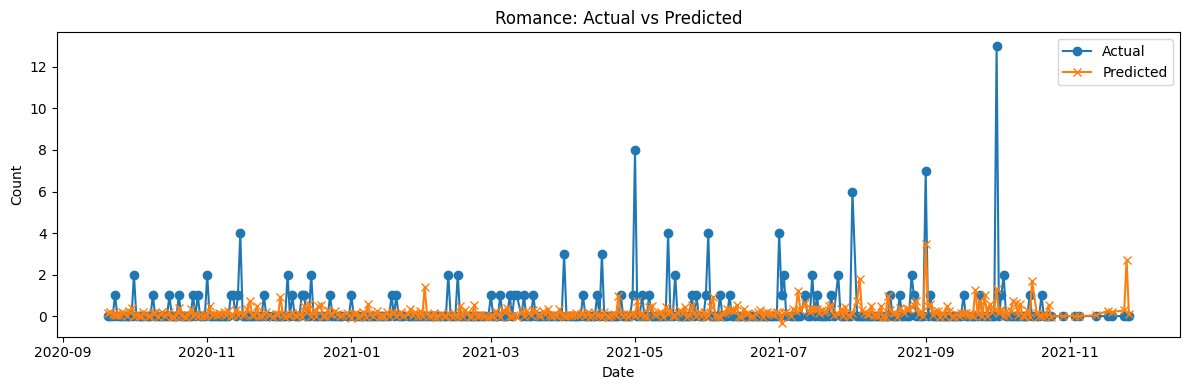

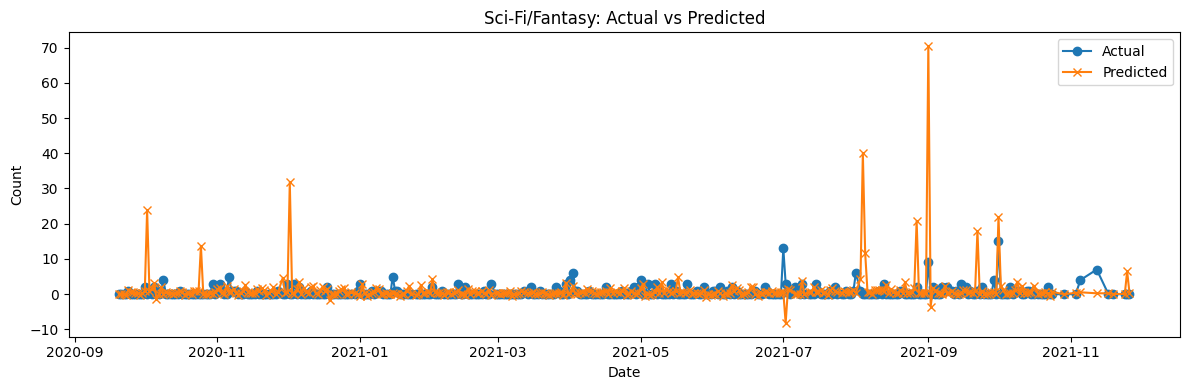

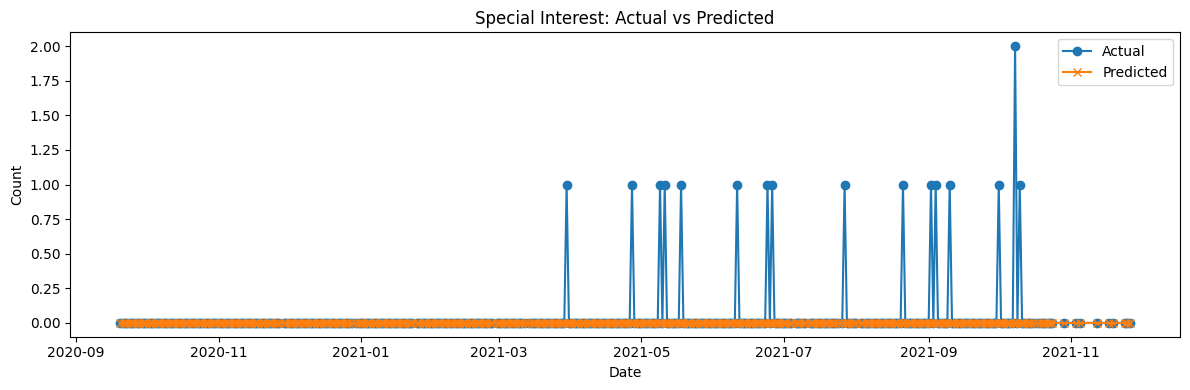

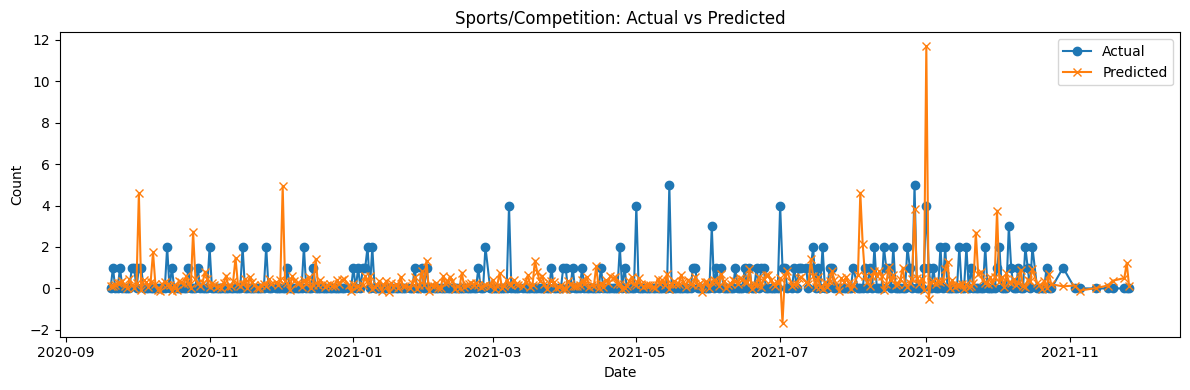

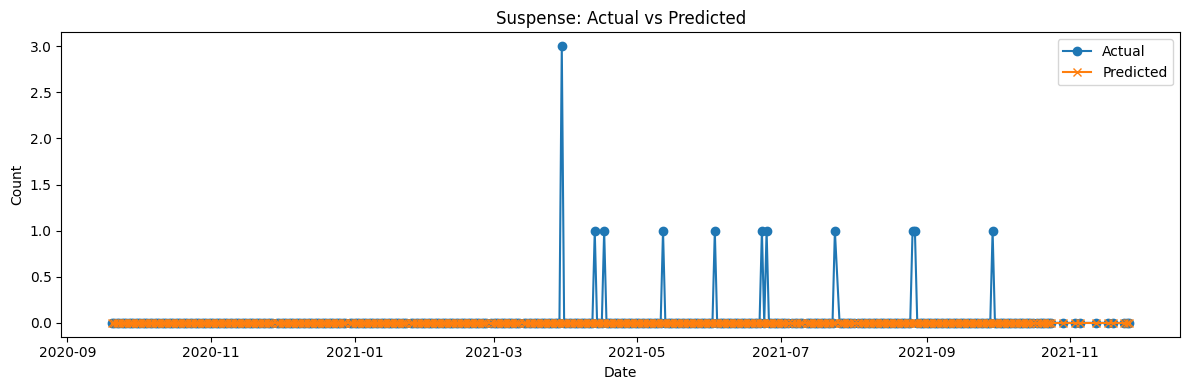

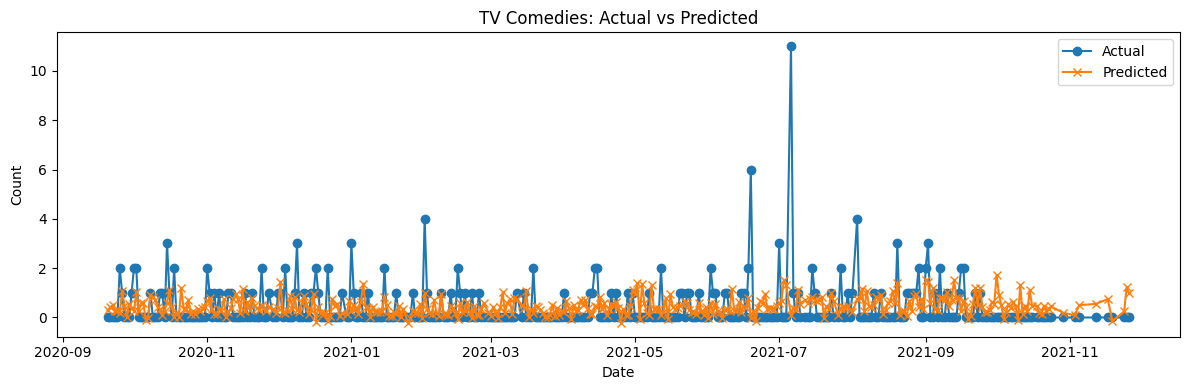

In [89]:
import matplotlib.pyplot as plt

# preds_df: predictions from multi-output XGBoost
# y_test: actual counts
# date index: y_test.index

for col in y_test.columns:
    plt.figure(figsize=(12,4))
    plt.plot(y_test.index, y_test[col], label='Actual', marker='o')
    plt.plot(preds_df.index, preds_df[col], label='Predicted', marker='x')
    plt.title(f'{col}: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

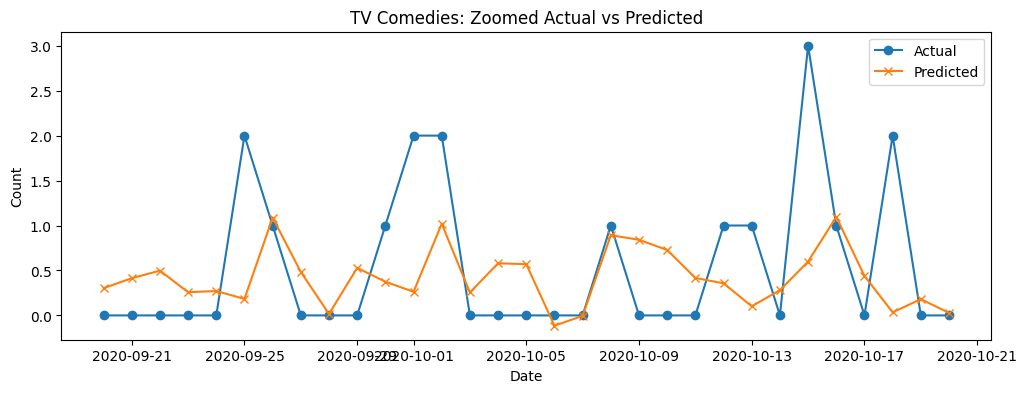

In [90]:
start_date = y_test.index.min()
end_date = start_date + pd.Timedelta(days=30)
mask = (y_test.index >= start_date) & (y_test.index <= end_date)

plt.figure(figsize=(12,4))
plt.plot(y_test.index[mask], y_test[col][mask], label='Actual', marker='o')
plt.plot(preds_df.index[mask], preds_df[col][mask], label='Predicted', marker='x')
plt.title(f'{col}: Zoomed Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

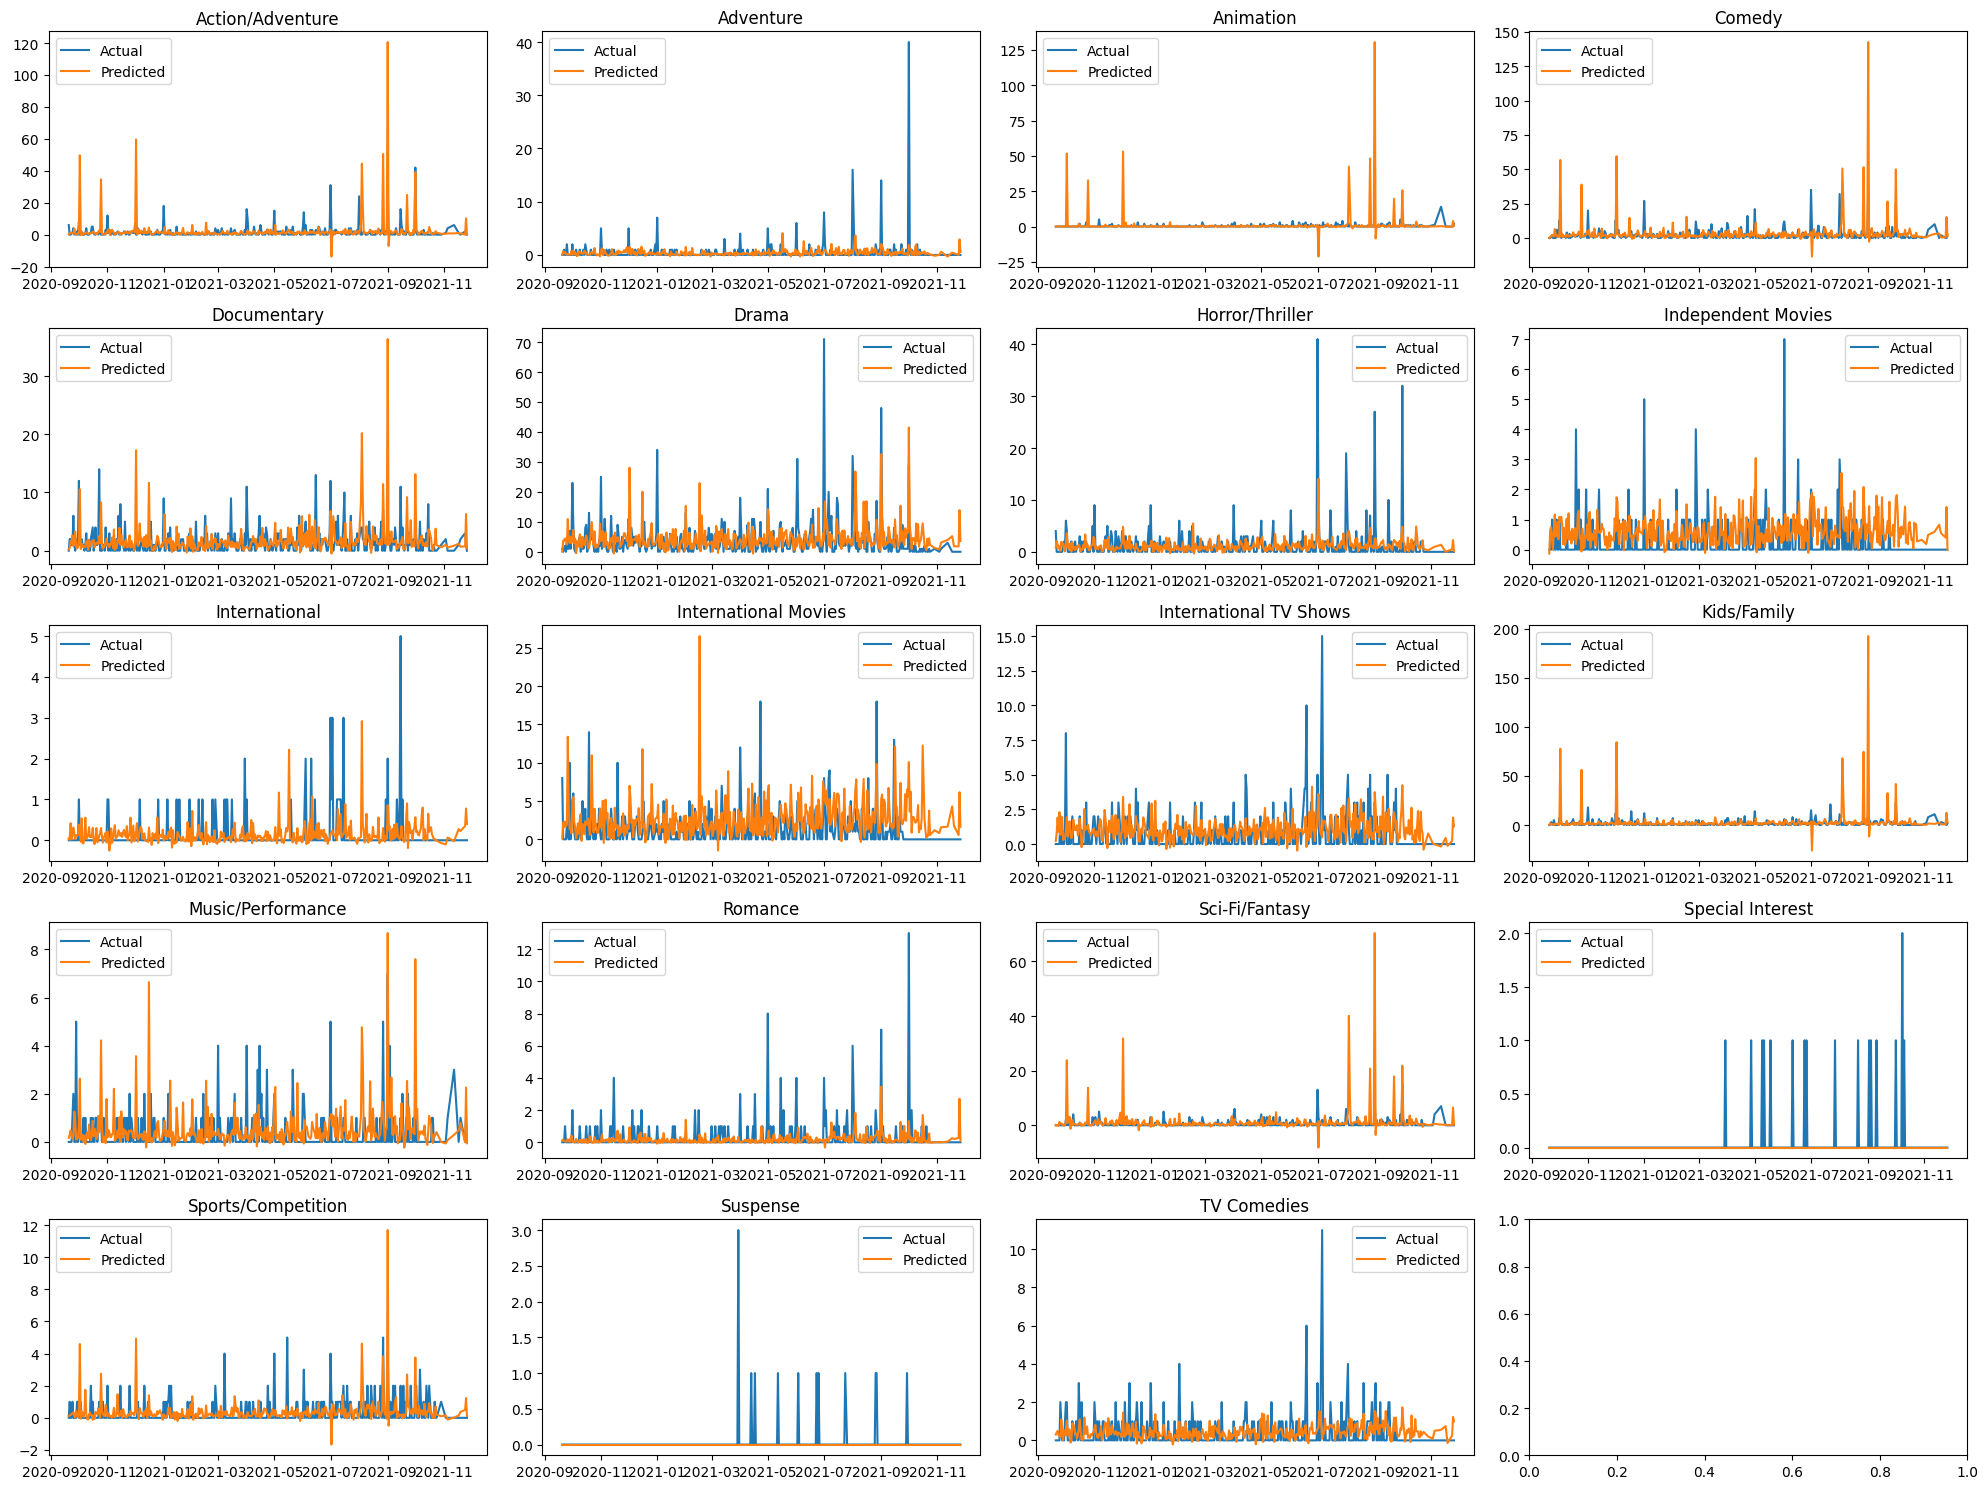

In [91]:
fig, axes = plt.subplots(5, 4, figsize=(20,15))
axes = axes.flatten()

for i, col in enumerate(y_test.columns):
    axes[i].plot(y_test.index, y_test[col], label='Actual')
    axes[i].plot(preds_df.index, preds_df[col], label='Predicted')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()